# Spam Comments Detection

## Tahap 1: Data Preparation and Data Cleaning
------------------------------------------------

##### **Daftar Isi pada Notebook**
1. Background - Latar belakang pembuatan projek dan sumber data yang digunakan hingga tujuan penelitian
2. Notebook Setup - mengimport package dan data
3. Overview data
5. Data Cleaning
   - lowercase
   - remove punctuation 
   - remove white spaces
6. Feature Extraction
    - url_ratio
    - urlcount
    - Number of white spce
    - word duplicate ratio
    - count emoji
    - stpopword ratio
    - count non ascii letter
    - count upper letters
7. Export data yang telah dilakukan prepocessing kedalam format .csv

------------------------------------------------------

**1. Background**

**Latar Belakang Project**



**Tujuan Project**
Pada project kali ini pendeteksian komentar spam dilakukan untuk menemukan komentar yang tidak relevan berisikan "promosi" sehingga hasilnya dapat digunakan untuk mengetahui sebuah komentar yang relevan dengan konten videonya. 


---------------------------------------------------

**Sumber Data**

Data yang digunakan berasal dari YouTube dengan melakukan crawling data menggunakan YouTube Data API. Mengekstrak dataset berdasarkan query yang telah dipilih, kemudian untuk memperoleh komentar dengan videoId menggunakan videoId.

Metadata yang dipilih anatara lain:
- videoId
- Tittle Video
- Name (username)
- Commment
- CommentId
- Time
- Like
- Reply Count
- Label

---------------------------------------------------

**Notebook Setup**

In [45]:
import pandas as pd
import glob
import os
import regex as re
import emoji
import pandas as pd
import numpy as np
import time
import string
from string import punctuation
import seaborn as sns
import emoji
from unidecode import unidecode
#from nltk.tokenize import word_tokenize
import datetime
from nltk.util import ngrams
from collections import Counter
from tokenize import group
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from tqdm import tqdm
from textblob import TextBlob
#import pycrfsuite
from tokenize import group
#from nltk.tag import CRFTagger
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
#from spacy.lang.id import Indonesian
#from spacy.lang.id.stop_words import STOP_WORDS
import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv("..\Data\Data Label\DataLabel.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002 entries, 0 to 3001
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Video_Id     3002 non-null   object 
 1   Tittle       3002 non-null   object 
 2   Description  3002 non-null   object 
 3   Name         3002 non-null   object 
 4   Comment      3002 non-null   object 
 5   Comment_Id   3002 non-null   object 
 6   Time         3002 non-null   object 
 7   Likes        3002 non-null   int64  
 8   Reply_Count  2623 non-null   float64
 9   Label        3002 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 234.7+ KB


In [3]:
df["Label"] = df["Label"].astype("category")
df["Time"] = df["Time"].astype("datetime64")

In [4]:
df.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label
2970,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Imam Arief Hidayat,Keren banget sumpah.... Kreatif... iklan ga gw...,Ugx8cJEFEAexPHtneUF4AaABAg,2019-04-09 07:21:20,0,0.0,legitimate


In [5]:
data = df.drop_duplicates(subset=["Comment"], keep=False)

In [6]:
B, K = data.shape
print(f"Banyaknya Saat ini adalah Baris: {B} dan Kolom: {K}")

Banyaknya Saat ini adalah Baris: 2846 dan Kolom: 10


In [7]:
data.isnull().sum()

Video_Id         0
Tittle           0
Description      0
Name             0
Comment          0
Comment_Id       0
Time             0
Likes            0
Reply_Count    350
Label            0
dtype: int64

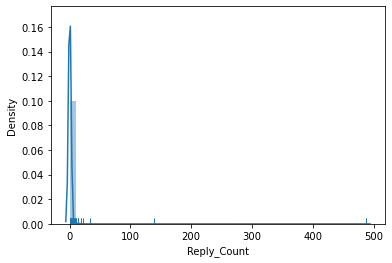

In [8]:
p = sns.distplot(data['Reply_Count'], kde=True, rug=True)

In [9]:
data['Reply_Count'].fillna(data['Reply_Count'].median(),inplace=True)

In [10]:
data.isnull().sum()

Video_Id       0
Tittle         0
Description    0
Name           0
Comment        0
Comment_Id     0
Time           0
Likes          0
Reply_Count    0
Label          0
dtype: int64

In [11]:
data["Reply_Count"] = data["Reply_Count"].astype("int64")

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2846 entries, 0 to 3001
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Video_Id     2846 non-null   object        
 1   Tittle       2846 non-null   object        
 2   Description  2846 non-null   object        
 3   Name         2846 non-null   object        
 4   Comment      2846 non-null   object        
 5   Comment_Id   2846 non-null   object        
 6   Time         2846 non-null   datetime64[ns]
 7   Likes        2846 non-null   int64         
 8   Reply_Count  2846 non-null   int64         
 9   Label        2846 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(2), object(6)
memory usage: 225.2+ KB


In [13]:
data.describe()

,Likes,Reply_Count
count,2846.000000,2846.000000
mean,33.689037,0.380183
std,1631.334031,9.589659
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,87019.000000,488.000000


In [14]:
data.sample(10)

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label
1108,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Khoirul Anwar,IKUT TRENDING https://youtu.be/qlB7vg4I-To #I...,UgzKRIa4EX81hnPJvwt4AaABAg,2019-04-15 18:03:31,0,0,spam
2495,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Heny Recoferry,Prabowo pasti menang,UgzR4Ll98YFlQ1V0sid4AaABAg,2019-04-13 07:23:38,1,0,legitimate
2600,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,AN,saya juga gan awal nya dukung prabowo karna te...,UgwPkb6_YvHZIx9PF194AaABAg.8tX3GOpryia8tX3VRtC3-t,2019-04-10 00:52:14,0,0,legitimate
2168,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Mono Ch,epic good,Ugxu-O8whnAuRuL1W_V4AaABAg,2019-04-10 16:19:42,0,0,legitimate
1283,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,jobit M,"Lets subscribe, like and share my Youtube chan...",UgyipT40Xm4GAdN_Cjp4AaABAg,2020-08-07 18:25:12,0,0,spam
1370,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Angga Kusuma,Biasa otaknya rada rada,UgwpMC4Xm6-d3PpgGy14AaABAg.8qD2lUu_bbi8qDmEiLn26c,2019-01-17 23:32:55,1,0,legitimate
972,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Sabit Berce,Gila nih keren parah jangan lupa mampir gue yah😊,UgxZDv9427sF3I8lc_Z4AaABAg,2019-04-12 09:53:21,1,0,spam
230,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Heldian Veter,https://youtu.be/yu-CDoB3LGQ,UgxsRJUy_m3A5Y2p2HZ4AaABAg,2019-04-14 10:44:14,0,0,spam
2280,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Vivien Rahardhani,Kalian liat gak bagian akhir dari viedo ini? P...,UgyIpEvi1H8BlFOf6CN4AaABAg,2019-12-15 03:45:54,0,0,legitimate
1508,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Raihan Dwi Wicaksono,Itu yang menjadi anak kecil nya kurang deh ekt...,UgxN5AIM-zaYDr-1gDt4AaABAg,2019-04-19 11:30:31,0,0,legitimate


## EDA (Exploratory Data Analysis)

### Comments that got the most 

In [14]:
like = data[data['Likes']== data['Likes'].max()]
print("Komentar dengan like terbanyak adalah \n {}".format(like.iloc[0].Comment))

Komentar dengan like terbanyak adalah 
 Official Teaser Trailer Film Bucin. Tayang Maret 2020. https://www.youtube.com/watch?v=rdLn2rcJjk0
Update terbaru: Video paling populer no 1 di Indonesia tahun 2019. Terima kasih semuanya!
Prabowo Vs Jokowi - Behind The Scenes Epic Rap Battles Of Presidency
 https://www.youtube.com/watch?v=N1X4WmVMRMg
Prabowo VS Jokowi - Epic Rap Battles Of Presidency - Bedah Lirik - Jenius (Genius Parody) https://youtu.be/AYK71Exj0M0
Prabowo Vs Jokowi - Bedah Lirik Part 2 https://youtu.be/prSN3P5fb0o
Prabowo VS Jokowi - Epic Rap Battles Of Presidency (Green Screen Cut) https://youtu.be/1Ofs0y0ZeTg


### 10 YouTube Account that comments have most reply

In [15]:
account = data['Name'].value_counts().head(10)
account = pd.DataFrame(data=account)
account.reset_index(inplace=True)
account = account.rename(columns = {"index" : "Youtube_Account",
                                    'Name': "reply_count"})
fig = px.bar(account, x='Youtube_Account', y='reply_count',
            color='Youtube_Account', title='10 YouTube Account that comments have most reply')
fig.show()

### Peak time to comments

In [17]:
peak_time = data.copy()
times = peak_time['Time']

In [18]:
peak_time["Date"] = peak_time["Time"].dt.day_name()
peak_time.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Date
1839,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Aditya Mahendra,Wow persaingan yg mantap,Ugyb3jPeQ5KrxirHCfl4AaABAg,2019-04-08 14:09:40,0,0,legitimate,Monday


In [19]:
def time(date):
    Time = date.time()
    return Time

peak_time['Period'] = times.map(time)
peak_time['Period'].head()

0    23:06:24
1    22:40:00
2    02:50:06
3    12:25:49
4    16:00:05
Name: Period, dtype: object

In [20]:
def time_groups(time):
    if time >= datetime.time(0,0) and time <= datetime.time(1,0):
        return '24:00 - 01:00'
    elif time >= datetime.time(1,0) and time <= datetime.time(2,0):
        return '01:00 - 02:00 '
    elif time >= datetime.time(2,0) and time <= datetime.time(3,0):
        return '02:00 - 03:00 '
    elif time >= datetime.time(3,0) and time <= datetime.time(4,0):
        return '03:00 - 04:00'
    elif time >= datetime.time(4,0) and time <= datetime.time(5,0):
        return '04:00 - 05:00'
    elif time >= datetime.time(5,0) and time <= datetime.time(6,0):
        return '05:00 - 06:00 '
    elif time >= datetime.time(6,0) and time <= datetime.time(7,0):
        return '06:00 - 07:00 '
    elif time >= datetime.time(7,0) and time <= datetime.time(8,0):
        return '07:00 - 08:00 '
    elif time >= datetime.time(8,0) and time <= datetime.time(9,0):
        return '08:00 - 09:00 '
    elif time >= datetime.time(9,0) and time <= datetime.time(10,0):
        return '09:00 - 10:00 '
    elif time >= datetime.time(10,0) and time <= datetime.time(11,0):
        return '10:00 - 11:00 '
    elif time >= datetime.time(11,0) and time <= datetime.time(12,0):
        return '11:00 - 12:00'
    elif time >= datetime.time(12,0) and time <= datetime.time(13,0):
        return '12:00 - 13:00'
    elif time >= datetime.time(13,0) and time <= datetime.time(14,0):
        return '13:00 - 14:00'
    elif time >= datetime.time(14,0) and time <= datetime.time(15,0):
        return '14:00 - 15:00'
    elif time >= datetime.time(15,0) and time <= datetime.time(16,0):
        return '15:00 - 16:00'
    elif time >= datetime.time(16,0) and time <= datetime.time(17,0):
        return '16:00 - 17:00'
    elif time >= datetime.time(17,0) and time <= datetime.time(18,0):
        return '17:00 - 18:00'
    elif time >= datetime.time(18,0) and time <= datetime.time(19,0):
        return '18:00 - 19:00'
    elif time >= datetime.time(19,0) and time <= datetime.time(20,0):
        return '19:00 - 20:00'
    elif time >= datetime.time(20,0) and time <= datetime.time(21,0):
        return '20:00 - 21:00'
    elif time >= datetime.time(21,0) and time <= datetime.time(22,0):
        return '21:00 - 22:00'
    elif time >= datetime.time(22,0) and time <= datetime.time(23,0):
        return '22:00 - 23:00'
    else:
        return '23:00 - 24:00'

In [22]:
peak_time["Period_groups"] = peak_time['Period'].map(time_groups)
peak_time.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Date,Period,Period_groups
1967,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,BORAX GAMING,Bapak Tau Apa Soal Ngantri,UgxfmxtD_0CUjTcxuih4AaABAg,2019-05-07 15:46:51,1,0,legitimate,Tuesday,15:46:51,15:00 - 16:00


In [23]:
time_group = peak_time['Period_groups'].value_counts().head(10)
time_group = pd.DataFrame(data=time_group)
time_group.reset_index(inplace=True)
time_group = time_group.rename(columns = {'index':'Time','Period_groups':'Most Comment'})
time_group

fig2 = px.bar(time_group, x='Time', y='Most Comment', 
              color='Time', title = 'Peak Time Comments Video', height=400)
fig2.show()

In [24]:
LabelTime = peak_time.groupby(['Period_groups', 'Label']).size().reset_index(name='counts')\
                            .sort_values(['Period_groups'], ascending=False)

In [25]:
LabelTime.sample()

,Period_groups,Label,counts
13,07:00 - 08:00,spam,62


In [26]:
LabelTime = LabelTime.rename(columns={'counts':'Total'})
fig2 = px.bar(LabelTime, x='Period_groups', y='Total', 
              color='Label', title = 'Peak Time Comments Based on Label', barmode="group", width=1200, height=600)
fig2.show()

In [42]:
day_group = peak_time['Date'].value_counts().head(7)
day_group = pd.DataFrame(data=day_group)
day_group.reset_index(inplace=True)
day_group = day_group.rename(columns = {'index':'Day','Date':'Most Comment'})
day_group

fig2 = px.bar(day_group, x='Day', y='Most Comment', 
              color='Day', title = 'Peak Day Comments Video', height=400)
fig2.show()

In [27]:
LabelDay = peak_time.groupby(['Date', 'Label']).size().reset_index(name='counts')\
                            .sort_values(['Date'], ascending=False)

In [28]:
LabelDay

,Date,Label,counts
12,Wednesday,legitimate,282
13,Wednesday,spam,224
10,Tuesday,legitimate,410
11,Tuesday,spam,240
8,Thursday,legitimate,206
9,Thursday,spam,189
6,Sunday,legitimate,138
7,Sunday,spam,115
4,Saturday,legitimate,166
5,Saturday,spam,141


In [29]:
LabelDay = LabelDay.rename(columns={'counts':'Total'})
fig2 = px.bar(LabelDay, x='Date', y='Total', 
              color='Label', title = 'Peak Day Comments Based on Label', barmode="group", width=1200, height=600)
fig2.show()

### Spam and Legitimate Comments Histogram

In [30]:
label = peak_time['Label'].value_counts().head(7)
label = pd.DataFrame(data=label)
label.reset_index(inplace=True)
label = label.rename(columns = {'index':'Kind of Label','Label':'Count a Spam or Legitimate'})
label

fig2 = px.bar(label, x='Kind of Label', y='Count a Spam or Legitimate', 
              color='Kind of Label', title = 'Spam or Legitimate Comments', width=500, height=600)
fig2.show()

## **ToyData**

**toyData** dibuat untuk mempermudah hasil proses cleaning maupun feature extraction yang sedang dicoba serta bertujuan sebagai sample data yang akan ditampilkan pada hasil seminar hasil dan sidang skripsi.

### Cleaning Text

In [15]:
toyData = pd.read_csv("../Data/Comments/toyData.csv")

In [16]:
B, K = toyData.shape
print(f"Banyaknya Saat ini adalah Baris: {B} dan Kolom: {K}")

Banyaknya Saat ini adalah Baris: 10 dan Kolom: 10


In [17]:
toyData.isnull().sum()

Video_Id       0
Tittle         0
Description    0
Name           0
Comment        0
Comment_Id     0
Time           0
Likes          0
Reply_Count    1
Label          0
dtype: int64

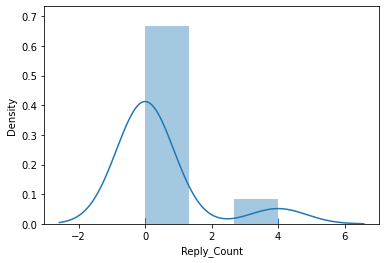

In [18]:
p = sns.distplot(toyData['Reply_Count'], kde=True, rug=True)

In [19]:
toyData['Reply_Count'].fillna(toyData['Reply_Count'].median(),inplace=True)

In [20]:
toyData.isnull().sum()

Video_Id       0
Tittle         0
Description    0
Name           0
Comment        0
Comment_Id     0
Time           0
Likes          0
Reply_Count    0
Label          0
dtype: int64

In [25]:
#NLTK_StopWords = stopwords.words('english')
factory = StopWordRemoverFactory()
Sastrawi_StopWords_id = factory.get_stop_words()

In [22]:
def lower(text):
    text = text.lower()
    return text

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def remove_emoji(text):
    pattern = emoji.get_emoji_regexp()
    without_emoji = pattern.sub('', text)
    return without_emoji

#def replace_url(text, replacement):
    text = str(text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    text = re.sub('[/]?watch(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    return text

'''Detect link and replace with url'''
urlregex = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")

def detecturl(text):
    url_filtered_comment = re.sub(urlregex, ' ',text)
    return url_filtered_comment

def url(text):
    punc_table = {ord(c): None for c in punctuation}
    text ="".join(t if i % 2 else t.translate(punc_table) for (i, t) in enumerate(urlregex.split(text)))
    return text

def remove_punc_except_urls(s, punctuationRegex=r'#[^.?!,a-zA-Z0-9\.]'): #[^.,a-zA-Z0-9\n\.] #^a-zA-Z0-9\s
  # arrays to keep track of indices
  urlInds = []
  puncInds = []
  # find all the urls
  for m in re.finditer(r'(https?|ftp)://[^\s/$.?#].[^\s]*', s):
    urlInds.append((m.start(0), m.end(0)))
  # find all the punctuation
  for m in re.finditer(punctuationRegex, s):
    puncInds.append((m.start(0), m.end(0)))
  # start removing punctuation from end so that indices do not change
  puncInds.reverse()
  # go through each of the punctuation indices and remove the character if it is not inside a url
  for puncRange in puncInds:
    inUrl = False
    # check each url to see if this character is in it
    for urlRange in urlInds:
      if puncRange[0] >= urlRange[0] and puncRange[0] <= urlRange[1]:
        inUrl = True
        break
    if not inUrl:
      # remove the punctuation from the string
      s = s[:puncRange[0]] + s[puncRange[1]:]
  return s


#def detecturl(text, replace):
#    url_filtered_comment = re.sub(urlregex, replace,text)
#    return url_filtered_comment

'''hastags'''
#def fixTags(T):
#    getHashtags = re.compile(r"#(\w+)")
#    pisahtags = re.compile(r'[A-Z][^A-Z]*')
#    t = T
#    tagS = re.findall(getHashtags, T)
#    for tag in tagS:
#        proper_words = ' '.join(re.findall(pisahtags, tagS[0]))
#        t = t.replace('#' + tag, proper_words)
#    return t

#def getTags(T):
#    getHashtags = re.compile(r"#(\w+)")
#    tagS = re.findall(getHashtags, T)
    #isitag = []
    #for tag in tagS:       
    #    tag = '#'+tag
    #    isitag.append(tag)
    
#    return ', '.join(isitag)

'''remove punctuation'''
clean_spcl = re.compile('[/(){}\[\]\|!;$]')
clean_symbol = re.compile('[^.,a-zA-Z0-9\.]')
simbol = re.compile(r'#(^\w)')

def clean_punct(text):
    text = clean_spcl.sub(' ', text)
    #text = clean_symbol.sub(' ', text)
    return text

def hastag(text):   
    text = simbol.sub('', text)
    return text

def clean_symbols(text): #this function remove the #
    text = clean_symbol.sub(' ', text)
    return text

'''white_spaces'''
def white_spaces(text):
    single_char_pattern = re.compile(r'\s+')
    text = re.sub(pattern=single_char_pattern, repl=' ', string=text)
    return text

'''Stopwords Sastrawi'''
stopwords = set(Sastrawi_StopWords_id)

def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopwords) # hapus stopword dari kolom deskripsi
    return text

def en_stopwords(text):
    df=open('..\Stopwords_eng\stopwords_en.txt',"r",encoding="utf-8", errors='replace')
    en_stop = df.readlines()
    df.close()
    en_stop = [t.strip().lower() for t in en_stop]
    en_stop = set(en_stop)
    text = ' '.join(word for word in text.split() if word not in en_stop) # hapus stopword dari kolom deskripsi
    return text
    
def id_stopwords(text):
    df=open('..\Stopwords\stopwords.txt',"r",encoding="utf-8", errors='replace')
    id_stop = df.readlines()
    df.close()
    id_stop = [t.strip().lower() for t in id_stop]
    id_stop = set(id_stop)
    text = ' '.join(word for word in text.split() if word not in id_stop) # hapus stopword dari kolom deskripsi
    return text

'''Slangwords'''
def slang(text):
    df=open('../Slangwords/slangwords.txt',"r",encoding="utf-8", errors='replace')
    slangS = df.readlines()
    slangS = [t.split(":") for t in slangS]
    slangS = [[k.strip(), v.strip()] for k,v in slangS]
    slangS = {k:v for k,v in slangS}

    T = TextBlob(text).words
    
    for i,t in enumerate(T):
        if t in slangS.keys():
            T[i] = slangS[t]
        
    T =' '.join(T)

    return T

In [65]:
urlregex = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
punctuation = list(string.punctuation)
punctuation.remove("#")
punctuation.remove("@") #bcs in commentar field sometimes user share/promote their username
punctuation.remove("_") #bcs username instagram using underscore
punctuation.append("•")

def cleaning(text):
    text = text.lower()
    punc_table = {ord(c): None for c in punctuation}
    text ="".join(t if i % 2 else t.translate(punc_table) for (i, t) in enumerate(urlregex.split(text)))
    pattern = re.compile(r'\s+')
    text = re.sub(pattern=pattern, repl=' ', string=text)
    return text


In [37]:
stopwords = set(Sastrawi_StopWords_id)

def cleaning_with_stopwords(text):
    text = text.lower()
    punc_table = {ord(c): None for c in punctuation}
    text ="".join(t if i%2 else t.translate(string.punctuation) for (i, t) in enumerate(urlregex.split(text)))
    pattern = re.compile(r'\s+')
    text = re.sub(pattern=pattern, repl=' ', string=text)
    text = ' '.join(word for word in text.split() if word not in stopwords) # hapus stopword dari kolom deskripsi
    return text

In [28]:
text = toyData["Comment"][2]

In [29]:
text = "follow instagram aku""ya @dewirizki__                                https://youtu.be/cZkyOfhoMF8 versi 2"

In [30]:
cleaning_with_stopwords(text)

'follow instagram akuya @dewirizki__ https://youtu.be/czkyofhomf8 versi 2'

**Cleaned_Comment Toy Data**

*for toyData*

Pada proses cleaning comment pertama **melakukan** beberapa hal antara lain:
- lowercase string
- remove punctuation dengan pengecualian # dan @ karena ini bergantung dengan user on youtube yang mempromosikan username sosial medianya di kolom komentar

In [38]:
toyData["cleanTitle"] = toyData["Tittle"].apply(lambda x: cleaning(x))

In [39]:
toyData['cleanedComment'] = toyData['Comment'].apply(lambda x: cleaning(x))

In [40]:
toyData

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,cleanTitle,cleanedComment
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17T23:06:24Z,0,0.0,spam,panas jokowi vs prabowo saling serang soal kor...,https://youtu.be/lbkgyxnpmcu
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,GUGUS NTB_Si Luh Putu Sri Utari,Om Swastyastu🙏\nHari Kartini sudah dekat! Dala...,UgzbWRmjT5OKeSSBtaN4AaABAg,2019-04-18T01:15:38Z,29,4.0,spam,skinnyindonesian24 prabowo vs jokowi epic rap ...,om swastyastu🙏 hari kartini sudah dekat dalam ...
2,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,MBAH SEMAR OFFICIAL,https://youtu.be/AX-l8ZYTjhA,UgyOsI2ZNgcGjq_pget4AaABAg,2019-02-19T12:13:00Z,0,0.0,spam,full live debat kedua capres pemilu 2019 jokow...,https://youtu.be/ax-l8zytjha
3,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,Bakol Daster,Surat an-nazi'at hapalan anak2\nhttps://youtu....,UgxUlmW4iEMQSjwVbxB4AaABAg,2019-02-19T11:47:37Z,0,0.0,spam,full live debat kedua capres pemilu 2019 jokow...,surat annaziat hapalan anak2 https://youtu.be/...
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,REDHADITYA RADJAB,REAL TESTIMONI\n•\n•\nNEW NORMAL harus punya m...,UgypCpHwp6aAVFptegd4AaABAg,2020-08-09T06:50:48Z,0,0.0,spam,skinnyindonesian24 prabowo vs jokowi epic rap ...,real testimoni new normal harus punya muka ber...
5,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teddy Taufani,"Siapa yg merinding nonton ini video, like 😨",UgymWIjnqV3Z9JOVGkV4AaABAg,2019-04-10T08:49:44Z,1,0.0,legitimate,skinnyindonesian24 prabowo vs jokowi epic rap ...,siapa yg merinding nonton ini video like 😨
6,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Riska Amalia,Ngak tahu kah kabarnya papua juga merasa diboh...,UgzStrrzMVkeANhiC414AaABAg.8qD2VVBYdUu8qWQTAlgely,2019-01-25T05:19:29Z,0,0.0,legitimate,panas jokowi vs prabowo saling serang soal kor...,ngak tahu kah kabarnya papua juga merasa diboh...
7,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,Iputh channelh,siapaun yang menjadi pemimpin kedepannya kami ...,UgyFQM13K061MRW5ePV4AaABAg,2019-02-22T07:29:37Z,0,0.0,legitimate,full live debat kedua capres pemilu 2019 jokow...,siapaun yang menjadi pemimpin kedepannya kami ...
8,LU2p56QVUWA,Debat Jokowi Vs Prabowo Soal Ideologi &amp; Pe...,DebatCapres #DebatJokowiPrabowo #DebatKeempatC...,Tokoku5. id,Pokok e pak JOKOWI 2 periode 👍👍 \nkalau prabo...,Ugybh8aHiCkeMLnDzMZ4AaABAg,2019-03-31T08:25:32Z,2,0.0,legitimate,debat jokowi vs prabowo soal ideologi amp peme...,pokok e pak jokowi 2 periode 👍👍 kalau prabowo ...
9,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09T04:08:18Z,0,0.0,legitimate,skinnyindonesian24 prabowo vs jokowi epic rap ...,👆👆👆👆👆👆


In [58]:
toyData['cleanedComment'] = toyData['Comment'].apply(lambda x: cleaning_with_stopwords(x))

In [59]:
toyData.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,LengthComment,cleanTitle,cleanedComment,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters
6,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Prananda Putra,https://youtu.be/KqYVS_WhNkc,UgzMjSSFIJMpepi-Gqp4AaABAg,2019-04-11 09:33:10,0,0,spam,1,skinnyindonesian24 prabowo vs jokowi epic rap ...,https://youtu.be/kqyvs_whnkc,1,0,0.0,1.0,0,0,6


In [68]:
#convert text into lower case
#def convert_to_lower(text):
#    return text.lower()

#remove_numbers on text
#def remove_numbers(text):
#    number_pattern = r'\d+'
#    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
#    return without_number

#def remove_punctuation(text):
#    return text.translate(str.maketrans('', '', string.punctuation))

#Komentar spam cenderung memiliki jumlah spasi yang banyak 
#sehingga komentar tersebut memberikan dampak yang jauh lebih besar 
#bagi pengguna yang membacanya

#def remove_extra_white_spaces(text):
#    single_char_pattern = re.compile(r'\s+')
#    without_sc = re.sub(pattern=single_char_pattern, repl=' ', string=text)
#    return without_sc

#def remove_stopwords(text):
#    nlp = spacy.blank("id")
#    removed = []
#    stop_words = list(STOP_WORDS)
#    Teks = nlp(text)
#    #tokens = token.text(Teks)
#    for i in range(len(Teks)):
#        if Teks [i] not in stop_words:
#            removed.append(Teks[i])
#    return " ".join(removed)


## Feature Extraction

In [41]:
#count comments words length
def count_length(text):
    return len(text.split())

def url_ratio(text):
    pattern =(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
    #urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    urls = re.findall(pattern=pattern, string=text)
    url_char = 0
    for url in urls:
        url_char += len(url)
    return url_char/len(text)

def count_url(text):
    pattern =(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
    #urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    urls = re.findall(pattern=pattern, string=text)
    return len(urls)

def count_extra_white_spaces(text):
    single_char_pattern = r'\s+'
    without_sc = re.findall(pattern=single_char_pattern, string=text)
    return len(without_sc)

def word_duplicate_ratio(text):
    try:
        text = unidecode(text)
        unique_words = set()
        word = []
        for i in text:
            for d in text.split():      
                unique_words.add(d)
                word.append(d)
        td =len(word)
        return(len(unique_words)/td)
    except:
        if len(word) == 0:
            return 1 

def duplicate_ratio(text):
    try:
        text = unidecode(text)
        word = Counter(text.split())
        wordList = [k for k, v in word.items()]
        countWords =[j for j in word.values()]
        return (len(wordList)/sum(countWords))
    except:
        return 1

#def count_punctuation((text),(string.punctuation)):
#    count = lambda l1,l2: sum([1 for text in l1 if text in l2])
#    return count
    #df['count_punct'] = df.content.apply(lambda s: count(s, string.punctuation))
#def stopwords_ratio()

def non_ascii(text): #emoticon count as ascii characters
    pattern = (r'[^\x00-\x7f]')
    non_ascii_count = re.findall(pattern=pattern, string=text)
    return len(non_ascii_count)

def upper_letters(text):
    sum_upper_letters = sum(map(str.isupper, text))
    return sum_upper_letters

def count_emoji(text):
    emoji_list = []
    data = re.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    return len(emoji_list)

stopwords = set(Sastrawi_StopWords_id)
def stopword_ratio(text):
    try:
        stopword = set(list(word for word in text.split() if word in stopwords))
        word = [word for word in text.split()]
        return len(stopword)/len(word)
    except:
        return 0


![Similarity](../Image/Post-Comment%20Similarity.png "PostComment Similairity")

In order to compare the effectiveness of inter-comment similairty with features such as post-comment similarity, dengan menghitung post-comment similarity sama dengan inter-comment similarity yaitu dengan menggunakan *koefisien Jaccard dan Dice's* pada *n-gram*

In [88]:
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ") if word not in Stopwords]  
  #print("Sentence after removing stopwords:",words)
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [85]:
def ngram(text, n):
    n_gram =ngrams(text.split(), n)
    for word in n_gram:
        return word

In [52]:
def Jaccard_Similarity(text, post, ngram=1):
    text = unidecode(text)
    words=[word for word in text.split(" ") if word not in stopwords]  
    #print("Sentence after removing stopwords:",words)
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]

    post = unidecode(post)
    post = [word for word in post.split(" ") if word not in stopwords]  
    #print("Sentence after removing stopwords:",words)
    temp=zip(*[post[i:] for i in range(0,ngram)])
    post = [' '.join(ngram) for ngram in temp]
    
    # List the unique words in a document
    words_doc1 = set(ans) 
    #print(words_doc1)
    words_doc2 = set(post)
    #print(words_doc2)
    
    # Find the intersection of words list of doc1 & doc2
    intersection = words_doc1.intersection(words_doc2)

    # Find the union of words list of doc1 & doc2
    union = words_doc1.union(words_doc2)
        
    # Calculate Jaccard similarity score 
    # using length of intersection set divided by length of union set
    return float(len(intersection)) / len(union)

In [43]:
Jaccard_Similarity('jokowi vs prabowo', "apakah jokowi makan nasi")

{'jokowi', 'prabowo', 'vs'}
{'jokowi', 'makan', 'nasi'}


0.2

In [88]:
text = unidecode(text)
word = Counter(text.split())
print(word)
wordList = [k for k, v in word.items()]
print(wordList)
print(len(wordList))
countWords =[j for j in word.values()]
countWords = sum(countWords)
print(countWords)
print(len(wordList)/countWords)

Counter({'keren,tapi': 1, 'ini': 1, 'lebih': 1, 'keren': 1, ':': 1, 'https://www.youtube.com/watch?v=qymh2pk6hdu': 1})
['keren,tapi', 'ini', 'lebih', 'keren', ':', 'https://www.youtube.com/watch?v=qymh2pk6hdu']
6
6
1.0


In [128]:
unique_words = set()
word = []
for d in text.split():      
    unique_words.add(d)
    word.append(d)
td =len(word)
print(len(unique_words))
print(td)
print(len(unique_words)/td)

4
5
0.8


In [56]:
toyData['countUrl'] = toyData['Comment'].apply(lambda x: count_url(x))
toyData['LengthWord'] = toyData['Comment'].apply(lambda x: count_length(x))
toyData['WhiteSpacenum'] = toyData['Comment'].apply(lambda x: count_extra_white_spaces(x))
toyData['StopwordRatio'] = toyData['cleanedComment'].apply(lambda x: stopword_ratio(x))
toyData['WorldDuplicateRatio'] = toyData['cleanedComment'].apply(lambda x: duplicate_ratio(x))
toyData['CountEmoji'] = toyData['cleanedComment'].apply(lambda x: count_emoji(x))
toyData['CountNonAscii'] = toyData['cleanedComment'].apply(lambda x: non_ascii(x))
toyData['CountUpperLetters'] = toyData['Comment'].apply(lambda x: upper_letters(x))
toyData['SimilarityTitle'] = toyData.apply(lambda x: Jaccard_Similarity(x.cleanedComment, x.cleanTitle), axis=1)
toyData['SimilarityDesc'] = toyData.apply(lambda x: Jaccard_Similarity(x.cleanedComment, x.Description), axis=1)

In [57]:
toyData

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc,LengthWord
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17T23:06:24Z,0,0.0,spam,...,1,0,0.000000,1.000000,0,0,7,0.00,0.0,1
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,GUGUS NTB_Si Luh Putu Sri Utari,Om Swastyastu🙏\nHari Kartini sudah dekat! Dala...,UgzbWRmjT5OKeSSBtaN4AaABAg,2019-04-18T01:15:38Z,29,4.0,spam,...,1,48,0.142857,0.708333,5,5,16,0.00,0.0,49
2,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,MBAH SEMAR OFFICIAL,https://youtu.be/AX-l8ZYTjhA,UgyOsI2ZNgcGjq_pget4AaABAg,2019-02-19T12:13:00Z,0,0.0,spam,...,1,0,0.000000,1.000000,0,0,6,0.00,0.0,1
3,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,Bakol Daster,Surat an-nazi'at hapalan anak2\nhttps://youtu....,UgxUlmW4iEMQSjwVbxB4AaABAg,2019-02-19T11:47:37Z,0,0.0,spam,...,1,8,0.000000,1.000000,0,0,7,0.00,0.0,9
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,REDHADITYA RADJAB,REAL TESTIMONI\n•\n•\nNEW NORMAL harus punya m...,UgypCpHwp6aAVFptegd4AaABAg,2020-08-09T06:50:48Z,0,0.0,spam,...,0,319,0.075472,0.664495,11,20,111,0.00,0.0,320
5,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teddy Taufani,"Siapa yg merinding nonton ini video, like 😨",UgymWIjnqV3Z9JOVGkV4AaABAg,2019-04-10T08:49:44Z,1,0.0,legitimate,...,0,7,0.125000,1.000000,1,1,1,0.00,0.0,8
6,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Riska Amalia,Ngak tahu kah kabarnya papua juga merasa diboh...,UgzStrrzMVkeANhiC414AaABAg.8qD2VVBYdUu8qWQTAlgely,2019-01-25T05:19:29Z,0,0.0,legitimate,...,0,26,0.291667,0.958333,0,0,1,0.00,0.0,27
7,bY5xuL62xRM,FULL LIVE DEBAT Kedua Capres Pemilu 2019 -- Jo...,(TANPA jeda IKLAN) Tonton lagi FULL LIVE DEBAT...,Iputh channelh,siapaun yang menjadi pemimpin kedepannya kami ...,UgyFQM13K061MRW5ePV4AaABAg,2019-02-22T07:29:37Z,0,0.0,legitimate,...,0,15,0.250000,1.000000,0,0,0,0.00,0.0,16
8,LU2p56QVUWA,Debat Jokowi Vs Prabowo Soal Ideologi &amp; Pe...,DebatCapres #DebatJokowiPrabowo #DebatKeempatC...,Tokoku5. id,Pokok e pak JOKOWI 2 periode 👍👍 \nkalau prabo...,Ugybh8aHiCkeMLnDzMZ4AaABAg,2019-03-31T08:25:32Z,2,0.0,legitimate,...,0,25,0.076923,0.869565,4,4,11,0.08,0.0,26
9,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09T04:08:18Z,0,0.0,legitimate,...,0,0,0.000000,1.000000,6,6,0,0.00,0.0,1


In [57]:
toyData["cleanedComment"][7]

'dasar boneka pdiutang membengkaktka asingbpjs sana ngantri😎😎😎'

In [55]:
toyData.to_csv("../Data/Comments/toyDataCleaning.csv", index=False)

--------------------------------------------------------------------------------

## **All_Data for the cleaning data**

**Cleaned Comment** dan **Cleaned Tittle**

Pada proses cleaning comment pertama ini **melakukan** beberapa hal:
- lowercase text
- remove punctuation
dengan fungsi yang sudah dibuat yaitu ``def cleansing(text)``

In [66]:
data["cleanTittle"] = data["Tittle"].apply(lambda x: cleaning(x))

In [67]:
data["cleanComment"] = data["Comment"].apply(lambda x: cleaning(x))

In [68]:
data.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,LengthWord,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
1463,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Jihan Rossa,2:00 sumpah enak banget musiknyaaa,UgxukxONVgFTh3eWPHV4AaABAg,2019-04-12 03:01:28,0,0,legitimate,...,5,0,4,0.0,1.0,0,0,0,0.0,0.0


**feature extraction**

Feature extraction dengan menghitung fitur numerik ini untuk setiap komentar untuk menangkap karakteristik berbeda yang dapat membedakan komentar spam dengan komentar yang sah dengan lebih baik. Feature extraction in terdiri dari:
- Count Url
- Number of White Space
- Stopword ratio
- world duplicate ratio
- count emoji
- count non Ascii character
- count upper letters

In [62]:
data['LengthWord'] = data['Comment'].apply(lambda x: count_length(x))
data['countUrl'] = data['Comment'].apply(lambda x: count_url(x))
data['WhiteSpacenum'] = data['Comment'].apply(lambda x: count_extra_white_spaces(x))
data['StopwordRatio'] = data['cleanComment'].apply(lambda x: stopword_ratio(x))
data['WorldDuplicateRatio'] = data['cleanComment'].apply(lambda x: duplicate_ratio(x))
data['CountEmoji'] = data['cleanComment'].apply(lambda x: count_emoji(x))
data['CountNonAscii'] = data['cleanComment'].apply(lambda x: non_ascii(x))
data['CountUpperLetters'] = data['Comment'].apply(lambda x: upper_letters(x))
data['SimilarityTitle'] = data.apply(lambda x: Jaccard_Similarity(x.cleanComment, x.cleanTittle), axis=1)
data['SimilarityDesc'] = data.apply(lambda x: Jaccard_Similarity(x.cleanComment, x.Description), axis=1)

In [69]:
data.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,LengthWord,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
2900,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Herik CH,Petdjahhh..,UgzJnCf6dByy506objR4AaABAg,2019-04-09 14:07:22,0,0,legitimate,...,1,0,0,0.0,1.0,0,0,1,0.0,0.0


In [70]:
length = data[data['LengthWord']== data['LengthWord'].max()]
print("Komentar dengan panjang kata terbanyak adalah \n {}".format(length.iloc[0].cleanComment))

Komentar dengan panjang kata terbanyak adalah 
 real testimoni new normal harus punya muka bersihkenyal dan glowing dong 😍 no kusamkusam yaa guys redhafacialcare mengatasi masalah kulit wajah yang kusamberjerawatporipori besar bopengflekflek udah pake ini itu dan tidak ada perubahan yuukk pake @redhacream bikin muka glowing dan makin kinclong cream ini recomeded banget hasil yang didapat ✔️ kulit putih bersih cerah dan glowing ✔️ pori kecil dan super lembut ✔️ menghilangkan bekas jerawat dan flek ✔️ kulit cerah dan merona ✔️ kulit lebih shiny ✔️ menyamarkan scarbopeng ✔️ anti aging ✔️ hasil terlihat sejak pemakaian pertama ✔️ minim merahminim perih kelebihan cream gel kami cream gel dengan antioksidan tinggi sehingga tidak cepat berubah warna garansi dan dijamin bukan abal2 orderreseller bisa langsung wa 📲 62811171105 6281234300362 produk racikan yg sudah sesuai standar medis dan sudah bpom jadi aman pake ibu hamil dan ibu menyusui jangan samakan kualitas produk kami dengan produk seje

In [60]:
#try_data_cleaning["cleanComment"] = try_data_cleaning["cleanComment"].apply(lambda x: cleaning_with_stopwords(x))

In [71]:
data.to_csv("../Data/Comments/dataCleaning.csv", index=False)

In [61]:
#try_data_cleaning.to_csv("../Data/Comments/dataCleaning_with_stopwords.csv", index=False)